## Create timeseries of CMIP6 data for PICES LME´s

### Import, prepare, and setup

**Import modules**:
Import the necessary modules to read and work with CMIP6 data

In [1]:
import matplotlib
matplotlib.use('WebAgg')

# Date and time
from dateutil.relativedelta import relativedelta
import datetime

# Computational modules
import zarr
import dask.delayed as delayed
from dask import compute
import numpy as np
import pandas as pd
import xarray as xr
import gcsfs

# Plotting
from matplotlib import pyplot as plt
from matplotlib import cm
np.seterr(divide='ignore', invalid='ignore')
get_ipython().run_line_magic("matplotlib", "inline")
plt.rcParams["figure.figsize"] = 12, 6
get_ipython().run_line_magic("config", "InlineBackend.figure_format = 'retina'")

# Maps   
import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import rioxarray

# Additional modules required
import sys
!{sys.executable} -m pip install --user cmip6_preprocessing
!{sys.executable} -m pip install --user rioxarray
!{sys.executable} -m pip install --user xclim
!{sys.executable} -m pip install --user salem
# Local files and utility functions
sys.path.append("./subroutines/")
import pices
import xclim
import salem
xr.set_options(display_style='html', display_width=50)

#### Create a dask cluster
In Jupyterhub manually start a dask cluster and edit the Client tcp address below  

In [2]:
from dask.distributed import Client, progress
client = Client("tcp://127.0.0.1:39989") 
client

Client Scheduler: tcp://127.0.0.1:39989 Dashboard: /user/trondkr/proxy/8787/status,Cluster Workers: 4 Cores: 4 Memory: 15.77 GB


#### Setup CMIP6 requirements
This is where you specify the requirements you want of the data to extract from Google CLoud CMIP6 archive. You can specify 
a number of settings such as experiment_ids, member_ids, and source_ids, however keep in mind that not all models may have available the selected variable as output, which would end in an error. The configuration is created as a class which is used for our convenience containing local definitions of variables.

In [3]:
class Config_pices():
    df = pd.read_csv(
    "https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv"
)
    fs = gcsfs.GCSFileSystem(token="anon", access="read_only")
   
    grid_labels = ["gr"]  # Can be gr=grid rotated, or gn=grid native
    member_ids = ["r1i1p1f1"]  #
    experiment_ids = ["ssp585"]  #'abrupt-4xCO2',
    source_ids = ["CESM2"] #,"CESM2-WACCM"] #,"GFDL-CM4","GFDL-ESM4"]
    variable_ids = ["tos"]
    table_ids = [
        "Omon"
    ]  # Amon=atmospheric variables, Omon=Ocean variables, SImon=sea-ice variables
    dset_dict = {}
    start_date="1900-01-01"
    end_date="2100-08-01"
    LMES=['Northern Bering - Chukchi Seas','Hudson Bay','West Bering Sea','East Bering Sea','Sea of Japan',
                'Oyashio Current','California Current','Kuroshio Current','East China Sea',
                'South China Sea','Gulf of Alaska','Sea of Okhotsk','Yellow Sea']
    LMES=['California Current','Gulf of Alaska','East Bering Sea']

In [4]:
config_pices_obj = Config_pices()

#### Narratives of the CMIP6 Shared Socio-economic Pathways
**See this excellent in-depth explainer of the SSP's by Carbonbrief for more info.**

**SSP1**: Sustainability – Taking the Green Road (Low challenges to mitigation and adaptation)
The world shifts gradually, but pervasively, toward a more sustainable path, emphasizing more inclusive development that respects perceived environmental boundaries. Management of the global commons slowly improves, educational and health investments accelerate the demographic transition, and the emphasis on economic growth shifts toward a broader emphasis on human well-being. Driven by an increasing commitment to achieving development goals, inequality is reduced both across and within countries. Consumption is oriented toward low material growth and lower resource and energy intensity.

**SSP2**: Middle of the Road (Medium challenges to mitigation and adaptation)
The world follows a path in which social, economic, and technological trends do not shift markedly from historical patterns. Development and income growth proceeds unevenly, with some countries making relatively good progress while others fall short of expectations. Global and national institutions work toward but make slow progress in achieving sustainable development goals. Environmental systems experience degradation, although there are some improvements and overall the intensity of resource and energy use declines. Global population growth is moderate and levels off in the second half of the century. Income inequality persists or improves only slowly and challenges to reducing vulnerability to societal and environmental changes remain.

**SSP3**: Regional Rivalry – A Rocky Road (High challenges to mitigation and adaptation)
A resurgent nationalism, concerns about competitiveness and security, and regional conflicts push countries to increasingly focus on domestic or, at most, regional issues. Policies shift over time to become increasingly oriented toward national and regional security issues. Countries focus on achieving energy and food security goals within their own regions at the expense of broader-based development. Investments in education and technological development decline. Economic development is slow, consumption is material-intensive, and inequalities persist or worsen over time. Population growth is low in industrialized and high in developing countries. A low international priority for addressing environmental concerns leads to strong environmental degradation in some regions.

**SSP4**: Inequality – A Road Divided (Low challenges to mitigation, high challenges to adaptation)
Highly unequal investments in human capital, combined with increasing disparities in economic opportunity and political power, lead to increasing inequalities and stratification both across and within countries. Over time, a gap widens between an internationally-connected society that contributes to knowledge- and capital-intensive sectors of the global economy, and a fragmented collection of lower-income, poorly educated societies that work in a labor intensive, low-tech economy. Social cohesion degrades and conflict and unrest become increasingly common. Technology development is high in the high-tech economy and sectors. The globally connected energy sector diversifies, with investments in both carbon-intensive fuels like coal and unconventional oil, but also low-carbon energy sources. Environmental policies focus on local issues around middle and high income areas.

**SSP5**: Fossil-fueled Development – Taking the Highway (High challenges to mitigation, low challenges to adaptation)
This world places increasing faith in competitive markets, innovation and participatory societies to produce rapid technological progress and development of human capital as the path to sustainable development. Global markets are increasingly integrated. There are also strong investments in health, education, and institutions to enhance human and social capital. At the same time, the push for economic and social development is coupled with the exploitation of abundant fossil fuel resources and the adoption of resource and energy intensive lifestyles around the world. All these factors lead to rapid growth of the global economy, while global population peaks and declines in the 21st century. Local environmental problems like air pollution are successfully managed. There is faith in the ability to effectively manage social and ecological systems, including by geo-engineering if necessary.

In [5]:
def get_geometry_for_LME(LME_name):
    lme_file='./data/LME_64_180/lmes_64_180.shp'
      
    records = shpreader.Reader(lme_file)
    for LME_GEO, record in zip(records.geometries(), records.records()):
        
        if LME_name == record.attributes['LME_NAME']:
            return LME_GEO
    print("Unable to find Polygon for area {}".format(LME_name))


In [30]:
def create_LME_figure(config_pices_obj, ax, LMES, projection):
  
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)
    extent = [-252, -100, 10, 65]
    ax.set_extent(extent)
    
    colors = list(np.random.choice(range(100,200,1), size=len(config_pices_obj.LMES)+1))
    colors_rgb = [(c/255.,0/255.,120/255.) for c in colors]
    
    records = pices.get_LME_records()
    
    counter=0
    for LME_GEO, record in zip(records.geometries(), records.records()):
        LME_NAME = record.attributes['LME_NAME']
        LME_NUMBER = int(record.attributes['LME_NUMBER'])
        
        if (LME_NAME in LMES):
            print("=> LME_NAME {} ({})".format(LME_NAME,LME_NUMBER))
            ax.add_geometries([LME_GEO], projection,
                   facecolor=colors_rgb[counter], edgecolor='k')
           
            ax.annotate(s=LME_NUMBER, xy=LME_GEO.centroid.coords[0], color="white" ,fontsize=12)
            counter+=1
        else:
            ax.add_geometries([LME_GEO], projection,
                   facecolor='LightGray', edgecolor='k')  
    #plt.show()


=> LME_NAME East Bering Sea (1)
=> LME_NAME Gulf of Alaska (2)
=> LME_NAME California Current (3)


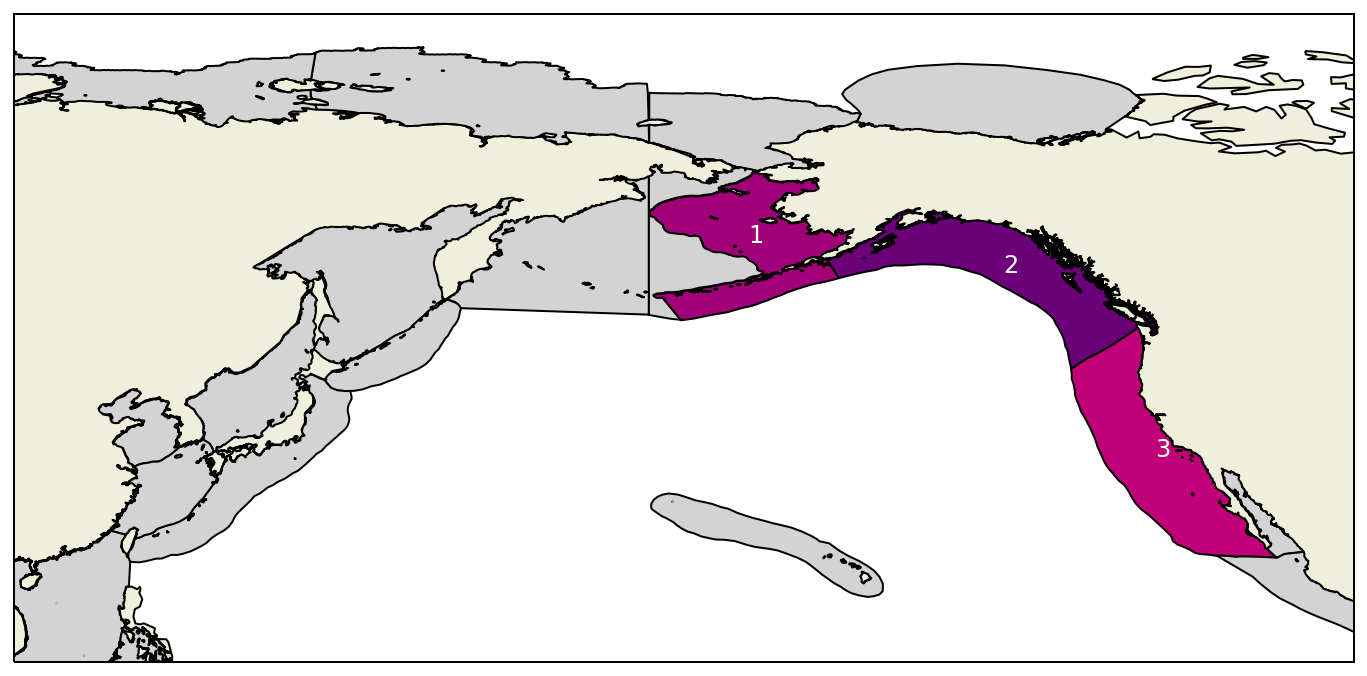

In [26]:
projection = ccrs.PlateCarree(central_longitude=-180)
ax = plt.axes(projection=projection)
create_LME_figure(config_pices_obj,ax,config_pices_obj.LMES, projection)

### Query data
The dataset returned from the query based on the previous setup, needs to be checked for time dimension as various CMIP6 models handle that differently. If the time array 
uses a relative date (e.g. 0001 instead of 2001) then we add 2000 prior to converting to 
datetime64 format.

This query also preprocesses the data so that various models are using the same naming, coordinates etc. according to https://github.com/jbusecke/cmip6_preprocessing

In [8]:
config_pices_obj = pices.get_and_organize_cmip6_data(config_pices_obj)

Running historical query on data: 
 ==> source_id=='CESM2'and table_id=='Omon' and grid_label=='gr' and experiment_id=='historical' and variable_id=='tos'

CESM2 => Dates extracted range from 1900-01-15 12:00:00 to 2100-07-15 12:00:00



LME:  California Current
=> LME_NAME California Current (3)
X: -131.5 -109.5
Y: 22.5 47.5


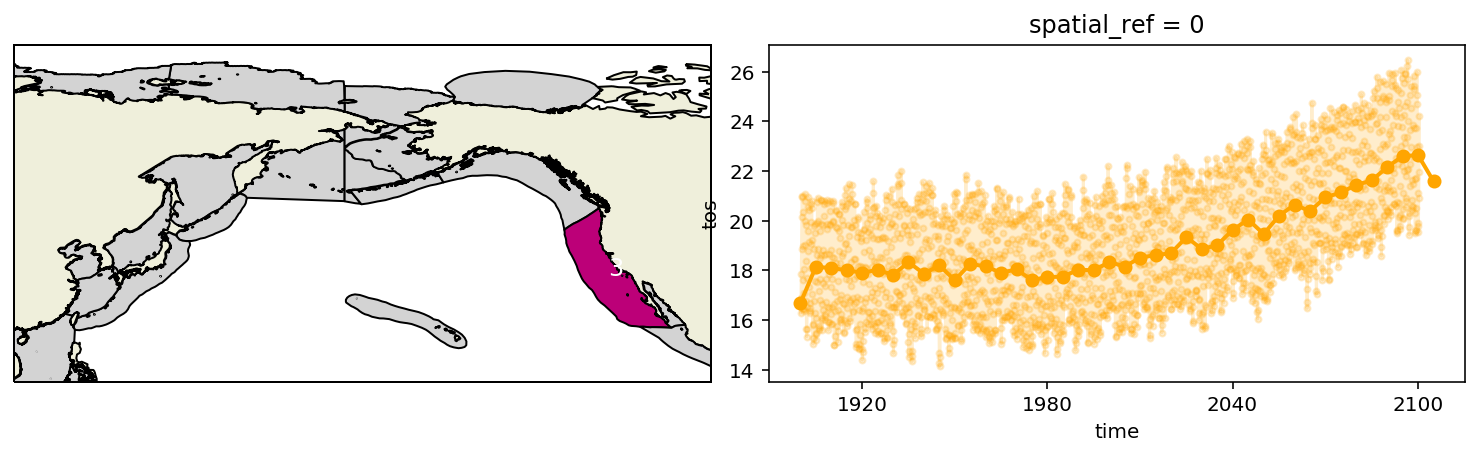

LME:  Gulf of Alaska
=> LME_NAME Gulf of Alaska (2)
X: -159.5 -122.5
Y: 44.5 60.5


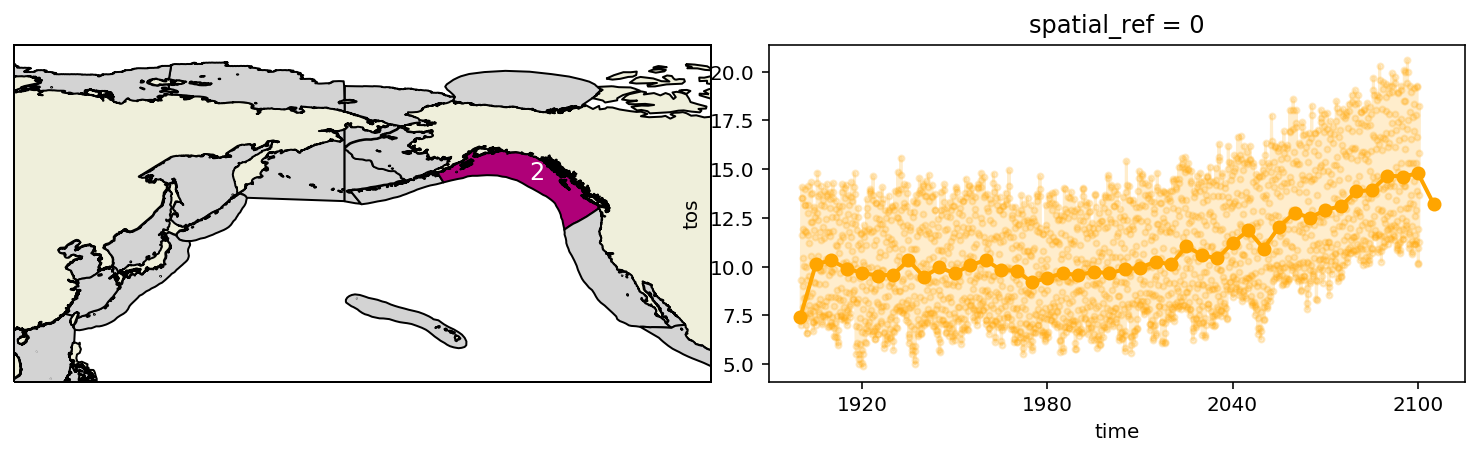

LME:  East Bering Sea
=> LME_NAME East Bering Sea (1)
X: -179.5 179.5
Y: 52.5 61.5


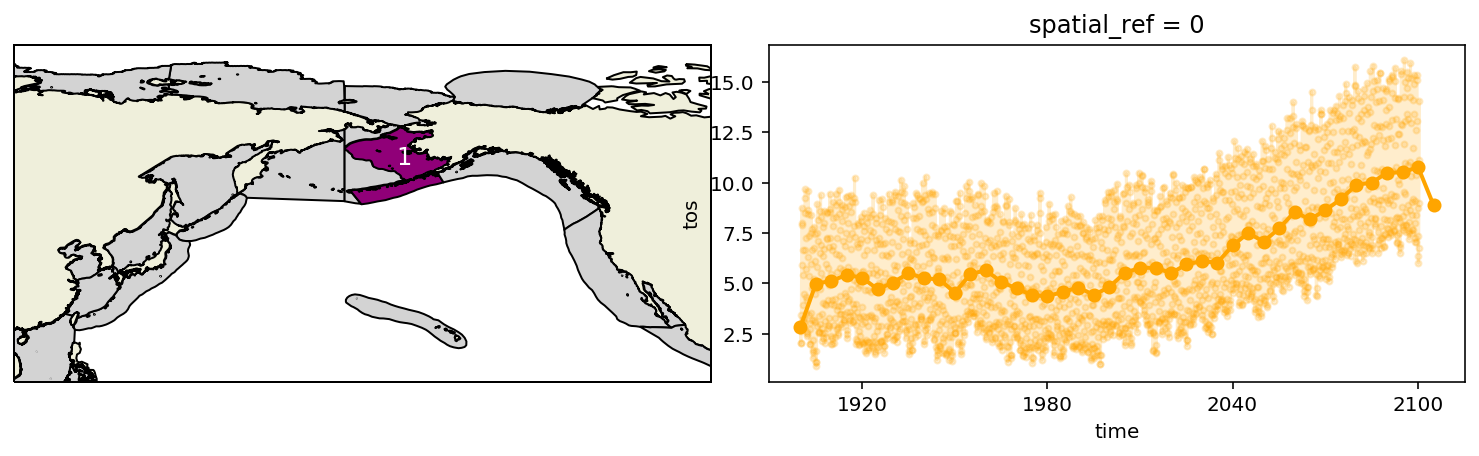

In [34]:

#ax.coastlines()
from xclim import subset
from pyproj import Geod
from pyproj.crs import CRS
import geopandas as gpd
from shapely.geometry import box, mapping
from mpl_toolkits.axes_grid1 import make_axes_locatable

extent = [-248, -100, 20, 85]
#ax.set_extent(extent)
#ax.add_feature(cfeature.LAND)
#ax.add_feature(cfeature.COASTLINE)

#records = pices.get_LME_records()
    
for key in config_pices_obj.dset_dict:
    ds=config_pices_obj.dset_dict[key]
   
    ds = ds.assign_coords(lon=(((ds.lon + 180) % 360) - 180)).sortby('lon')
    tos_proj = ds.tos.salem.transform(ds.tos)
    tos_proj=tos_proj.rename({"lon":"x", "lat":"y"})
    
    tos_proj.rio.set_crs("epsg:4326")
   # ds = pices.preprocessing_wrapper(ds)
  

    shp_dir='./data/LME/LME66.shp' #'./data/LME_64_180/lmes_64_180.shp'
    shdf = gpd.read_file(shp_dir)
    all_lmes=[]
    for LME_NAME in config_pices_obj.LMES:
        shdf_sel = shdf[ shdf['LME_NAME']==LME_NAME ]
        print("LME: ", LME_NAME)
        
        fig = plt.figure(figsize=(13, 8))
        projection=ccrs.PlateCarree(central_longitude=-180)
        ax1 = fig.add_subplot(111, projection=projection)

        create_LME_figure(config_pices_obj,ax1,[LME_NAME],projection)
        
        clipped = tos_proj.rio.clip(geometries=shdf_sel.geometry.apply(mapping), crs=tos_proj.rio.crs)
        print("X:", np.min(clipped.x.values),np.max(clipped.x.values))
        print("Y:", np.min(clipped.y.values),np.max(clipped.y.values))
        divider = make_axes_locatable(ax1)
        ax2 = divider.new_horizontal(size="100%", pad=0.4, axes_class=plt.Axes)
        fig.add_axes(ax2)

        clipped.mean(dim=["x","y"]).plot.line(color='orange', marker='.', ax=ax2, alpha=0.2)
        clipped.mean(dim=["x","y"]).resample(time="60M").mean().plot(ax=ax2, color='orange', marker='o', linewidth=2.0)
        
        all_lmes.append(clipped)

        plt.show()
    ds_lme=xr.merge(all_lmes)
    ds_lme = ds_lme.assign_coords(lon=(((ds.lon + 180) % 360) - 180)).sortby('lon')
    #ds_lme.tos.isel(time=0).plot(ax=ax, transform=ccrs.PlateCarree(), cmap='coolwarm')
    
    dd = ds_lme.tos.mean(dim=["x","y"])
   
   # dd.plot.line(color='purple', marker='o')
    plt.show()

In [ ]:
def create_timeseries_anomaly_figures(config_pices_obj):
    ds_pices360 = pices.get_pices_mask()
    ds_pices360 = convert_to_180_to_180(ds_pices360)
    
    fig = plt.figure(figsize=(12, 6))
    iregion=20
    variable_name='tos'
    
    grid = plt.GridSpec(2, 3, wspace=0.4, hspace=0.3)
    ax_tos=fig.add_subplot(grid[0, 1:])
    ax_klf=fig.add_subplot(grid[1, 1:])
    ax_map=fig.add_subplot(grid[0, 0])
    add_map_PICES_LME(ax_map,iregion)
    
    for i in range(1, 3):
     
        for key in config_pices_obj.dset_dict:

            ds=convert_to_180_to_180(config_pices_obj.dset_dict[key])
            mask_interp = ds_pices360.interp_like(ds,method='nearest') 

            cond = (mask_interp.region_mask==iregion)
            print("=> Region {}".format(iregion))

            area_ds = pices.weighted_mean_of_data(ds, cond)
            area_ds=area_ds.assign_coords(region=iregion)

            ds_climatology = area_ds[variable_name].groupby('time.month').mean('time',keep_attrs=True)
            ds_anomaly = (area_ds[variable_name].groupby('time.month') - ds_climatology)
            ds_anomaly.plot(ax=ax_tos)


    plt.show()


In [ ]:
create_timeseries_anomaly_figures(config_pices_obj)

**Read in the data for PICES**

In [ ]:
#mn, clim, anom = pices.get_pices_data("wind", 13, "1992-01-01", "2019-08-01")

**Read in PICES mask**
The basic PICES mask is -180 to 180 lon and -90 to 90 lat
Below different maps are created for 0 to 360 lon
Then each of the two different lon maps are also copied to reverse lat, 90 to -90

In [ ]:
#ds_pices360 = pices.get_pices_mask()